In [2]:
!pip install git+https://github.com/MinRegret/tigercontrol.git

  Cloning https://github.com/MinRegret/tigercontrol.git to /private/var/folders/7f/s33r9hxx1wg05ggrbzwk4zzc0000gn/T/pip-req-build-smelmas2
  Running command git clone -q https://github.com/MinRegret/tigercontrol.git /private/var/folders/7f/s33r9hxx1wg05ggrbzwk4zzc0000gn/T/pip-req-build-smelmas2
  Created wheel for tigercontrol: filename=tigercontrol-0.1-cp36-none-any.whl size=155312 sha256=50aeb5dadd63e0c0a3f14cf3a7dbb401e3d3e7dee3ec4c4a21b3604d7f815421
  Stored in directory: /private/var/folders/7f/s33r9hxx1wg05ggrbzwk4zzc0000gn/T/pip-ephem-wheel-cache-6y2yejhd/wheels/68/8c/d4/4545a6bf5fe7fde74989bdda96791b48a263e7ddc5d401a4e2
Successfully built tigercontrol
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import matplotlib.pyplot as plt
import jax.numpy as np
import tigercontrol
from tigercontrol.methods.control import ControlMethod
from jax import grad,jit
import jax
from tigercontrol.utils.random import set_key

ModuleNotFoundError: No module named 'tigercontrol'

In [2]:
def get_trajectory(problem, method, key = 0, T = 100):
    set_key(key)

    (problem_id, problem_params) = problem
    (method_id, method_params) = method
    
    problem = tigercontrol.problem(problem_id)
    x = problem.initialize(**problem_params)
    
    method_params['A'], method_params['B'] = problem.A, problem.B
    method_params['x'] = x
    
    method = tigercontrol.method(method_id)
    method.initialize(**method_params)
    
    trajectory = []
    norms = []
    avg_regret = []
    cur_avg = 0
    
    if(method.is_online):
        for i in range(T):
            u = method.plan(x)
            x = problem.step(u)
            trajectory.append(x) # get trajectory
            norms.append(np.linalg.norm(x))
            cur_avg = (i / (i + 1)) * cur_avg + np.linalg.norm(x) / (i + 1)
            avg_regret.append(cur_avg)
    else:
        u = method.plan()
        for i in range(T):
            x = problem.step(u[i])
            trajectory.append(x)
            norms.append(np.linalg.norm(x))
            cur_avg = (i / (i + 1)) * cur_avg + np.linalg.norm(x) / (i + 1)
            avg_regret.append(cur_avg)
            
    return trajectory, norms, avg_regret

In [10]:
T = 50

In [11]:
n = 3 # dimension of  the state x 
m = 5 # control dimension
noise_magnitude = 0.2
noise_distribution = 'normal'

problem_id = "LDS-v0"
problem_params = {'n': n, 'm' : m, 'noise_magnitude' : noise_magnitude, 'noise_distribution' : noise_distribution}

In [12]:
H, HH = 3, 30
GPC_params = {'n' : n, 'm' : m, 'H' : H, 'HH' : HH, 'K' : np.zeros((m, n))}

In [ ]:
GPC_results, GPC_norms, GPC_avg_results = get_trajectory((problem_id, problem_params), ('GPC', GPC_params), key = 0, T = T)

In [14]:
C = np.identity(n + m) # quadratic cost
LQR_params = {'C' : C, 'T' : T}

In [ ]:
LQR_results, LQR_norms, LQR_avg_results = get_trajectory((problem_id, problem_params), ('LQR', LQR_params), key = 0, T = T)

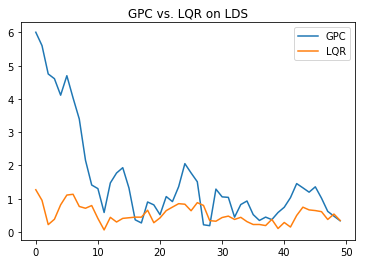

In [16]:
plt.plot(GPC_norms, label = "GPC")
plt.plot(LQR_norms, label = "LQR")
plt.title("GPC vs. LQR on LDS");
plt.legend();